## Bug Classifier
This is an automated model for the classification of issues as bugs. It is designed in such a way that it could be applied upon creation of an issue, i.e., as a recommendation system for users of the issue tracking system.

In [1]:
import pandas as pd
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
project_names = ['ant-ivy', 'archiva', 'calcite', 'cayenne', 'commons-bcel', 'commons-beanutils',
                 'commons-codec', 'commons-collections', 'commons-compress', 'commons-configuration', 
                 'commons-dbcp', 'commons-digester', 'commons-io', 'commons-jcs', 'commons-jexl', 'commons-lang', 
                 'commons-math', 'commons-net', 'commons-rdf', 'commons-scxml', 'commons-validator', 'commons-vfs', 
                 'deltaspike', 'eagle', 'giraph', 'gora', 'jspwiki', 'kylin', 'lens', 'mahout', 'manifoldcf', 
                 'nutch', 'opennlp', 'parquet-mr', 'santuario-java', 'systemml', 'tika', 'wss4j']

### The data is stored in .csv files

In [3]:
# This is commons-math project
df = pd.read_csv(f'csv_files/{project_names[16]}.csv')
df

,Description,Issue type,Title,Label
0,/*\n * Copyright 2003-2004 The Apache Software...,Improvement,Adding new methods to RealMatrix,1
1,,Bug,[math] fixed some javadoc and checkstyle warnings,0
2,I did some profiling on a project and found a ...,Bug,[patch] Gamma.logGamma performance,0
3,In MathUtilsTest I found the following code:\n...,Bug,[math] Failure to fail when testing for except...,0
4,Added text to the root finding portion of the ...,Bug,[math] user guide additions - root finding,0
...,...,...,...,...
1403,RealFieldElement in some cases could be used a...,Wish,Make RealFieldElement implement Number,1
1404,When created from boundaries consisting of two...,Bug,PolygonsSet does not handle intersecting infin...,0
1405,The o.a.c.m.geometry.euclidean.twod.PolygonsSe...,Bug,PolygonsSet.getBarycenter() returns incorrect ...,0
1406,I've found an infinite loop when recombining t...,Bug,Infinite loop for CycleCrossover with duplicates,0


### Dataframe with all projects

In [5]:
frames = []
for i in range(len(project_names)):
    frames.append(pd.read_csv(f'csv_files/{project_names[i]}.csv'))

df = pd.concat(frames)

In [6]:
# Concatenate description and title
df['DescriptionTitle'] = df['Description'] + ' ' + df['Title']

### Prepocessing the data

In [40]:
#### Show one of the concatenated lines
desc_title = df['DescriptionTitle'].tolist()
desc_title[4]

"a stack overflow error occurs when trying to force a revision which isn't the one selected during another conflict resolution. See http://www.jayasoft.org/node/365 for details. stack overflow error in some conflicts cases"

In [41]:
for i in range (len(desc_title)):
    # Convert sentence to lower case
    desc_title[i] = str(desc_title[i]).lower()
    # Remove Numbers
    desc_title[i] = re.sub(r'\d+', ' ', desc_title[i])
    # Remove the punctuation and empty spaces from the text
    desc_title[i] = re.sub(r'\W', ' ', desc_title[i])
    desc_title[i] = re.sub(r'\s+', ' ', desc_title[i])
    # Remove single word in regular expression
    desc_title[i] = re.sub(r'\b[a-zA-Z]\b', '', desc_title[i])

    
desc_title[4]

' stack overflow error occurs when trying to force  revision which isn  the one selected during another conflict resolution see http www jayasoft org node for details stack overflow error in some conflicts cases'

In [42]:
# Remove stop words
stopword = stopwords.words('english')

for i in range(len(desc_title)):
    word_tokens = word_tokenize(desc_title[i])
    desc_title[i] = [word for word in word_tokens if word not in stopword]

print(desc_title[4])

['stack', 'overflow', 'error', 'occurs', 'trying', 'force', 'revision', 'one', 'selected', 'another', 'conflict', 'resolution', 'see', 'http', 'www', 'jayasoft', 'org', 'node', 'details', 'stack', 'overflow', 'error', 'conflicts', 'cases']


In [43]:
# Stemming
stemmer = PorterStemmer()

for i in range(len(desc_title)):
    for j in range(len(desc_title[i])):
        desc_title[i][j] = stemmer.stem(desc_title[i][j])
        

In [44]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

for i in range(len(desc_title)):
    for j in range(len(desc_title[i])):
        desc_title[i][j] = lemmatizer.lemmatize(desc_title[i][j])
        

In [45]:
print('After stemming and lemmatization:')
print(desc_title[4])

After stemming and lemmatization:
['stack', 'overflow', 'error', 'occur', 'tri', 'forc', 'revis', 'one', 'select', 'anoth', 'conflict', 'resolut', 'see', 'http', 'www', 'jayasoft', 'org', 'node', 'detail', 'stack', 'overflow', 'error', 'conflict', 'case']


In [46]:
# Convert list to a string 
desc_title_string = []
for i in range(len(desc_title)):
    s = ' '.join(str(word) for word in desc_title[i])
    desc_title_string.append(s)  
    

In [47]:
# Update the column
df['DescriptionTitle'] = desc_title_string

### Training the model

In [54]:
# Remove missing values
df = df.dropna()

In [55]:
# TfidfVectorizer
# Split the data to training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df['DescriptionTitle'], df['Label'], random_state=1,
                                                    test_size=0.25)
print(f'Size of the training subset: {len(X_train)}')

tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf =tfidf.transform(X_test)

Size of the training subset: 29637


In [56]:
# CountVectorizer
# Split the data to training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Label'], random_state=1,
                                                    test_size=0.25)

print(f'Size of the training subset: {len(X_train)}')

# Remove stop word, change to lowercase, etc. 
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

Size of the training subset: 29637


In [65]:
def train_model(classifier, X_train, y_train, X_test, y_test):
    """Train the model with given parameters.
    
    Return accuracy score.
    """
    # Training
    classifier.fit(X_train, y_train)
    
    # Testing
    predictions = classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy score: ', accuracy)
    print('Precision score: ', precision_score(y_test, predictions))
    print('Recall score: ', recall_score(y_test, predictions))
    print('F1 score:', f1_score(y_test, predictions))
    
    return accuracy

### Naive Bayes

In [66]:
tf_acc = []
cv_acc = []

naive_bayes = MultinomialNB()

# TfidfVectorizer
acc = train_model(naive_bayes, X_train_tf, y_train, X_test_tf, y_test)
tf_acc.append(acc)

Accuracy score:  0.7767992711812937
Precision score:  0.7807959570435882
Recall score:  0.7610837438423645
F1 score: 0.7708138447146867


In [67]:
# CountVectorizer
acc = train_model(naive_bayes, X_train_cv, y_train, X_test_cv, y_test)
cv_acc.append(acc)

Accuracy score:  0.6432837331713737
Precision score:  0.5875552091452325
Recall score:  0.9283661740558292
F1 score: 0.7196499602227525


### Random Forest

In [68]:
rfc = RandomForestClassifier(random_state=0, n_estimators = 10)

# TfidfVectorizer
acc = train_model(rfc, X_train_tf, y_train, X_test_tf, y_test)
tf_acc.append(acc)

Accuracy score:  0.749164895232311
Precision score:  0.7750459558823529
Recall score:  0.6923234811165846
F1 score: 0.7313529921942756


In [69]:
# CountVectorizer
acc = train_model(rfc, X_train_cv, y_train, X_test_cv, y_test)
cv_acc.append(acc)

Accuracy score:  0.7340823970037453
Precision score:  0.7692492204365555
Recall score:  0.6582512315270936
F1 score: 0.7094347970357262


### Logistic Regression

In [70]:
log_reg = LogisticRegression(solver='liblinear', penalty='l1', C=0.9) 

# TfidfVectorizer
acc = train_model(log_reg, X_train_tf, y_train, X_test_tf, y_test)
tf_acc.append(acc)

Accuracy score:  0.8078752910213585
Precision score:  0.8158453695836874
Recall score:  0.7883825944170771
F1 score: 0.8018789144050105


In [71]:
# CountVectorizer
acc = train_model(log_reg, X_train_cv, y_train, X_test_cv, y_test)
cv_acc.append(acc)

Accuracy score:  0.7694098592974997
Precision score:  0.7550137632717263
Recall score:  0.7881773399014779
F1 score: 0.7712392046595702


### Results

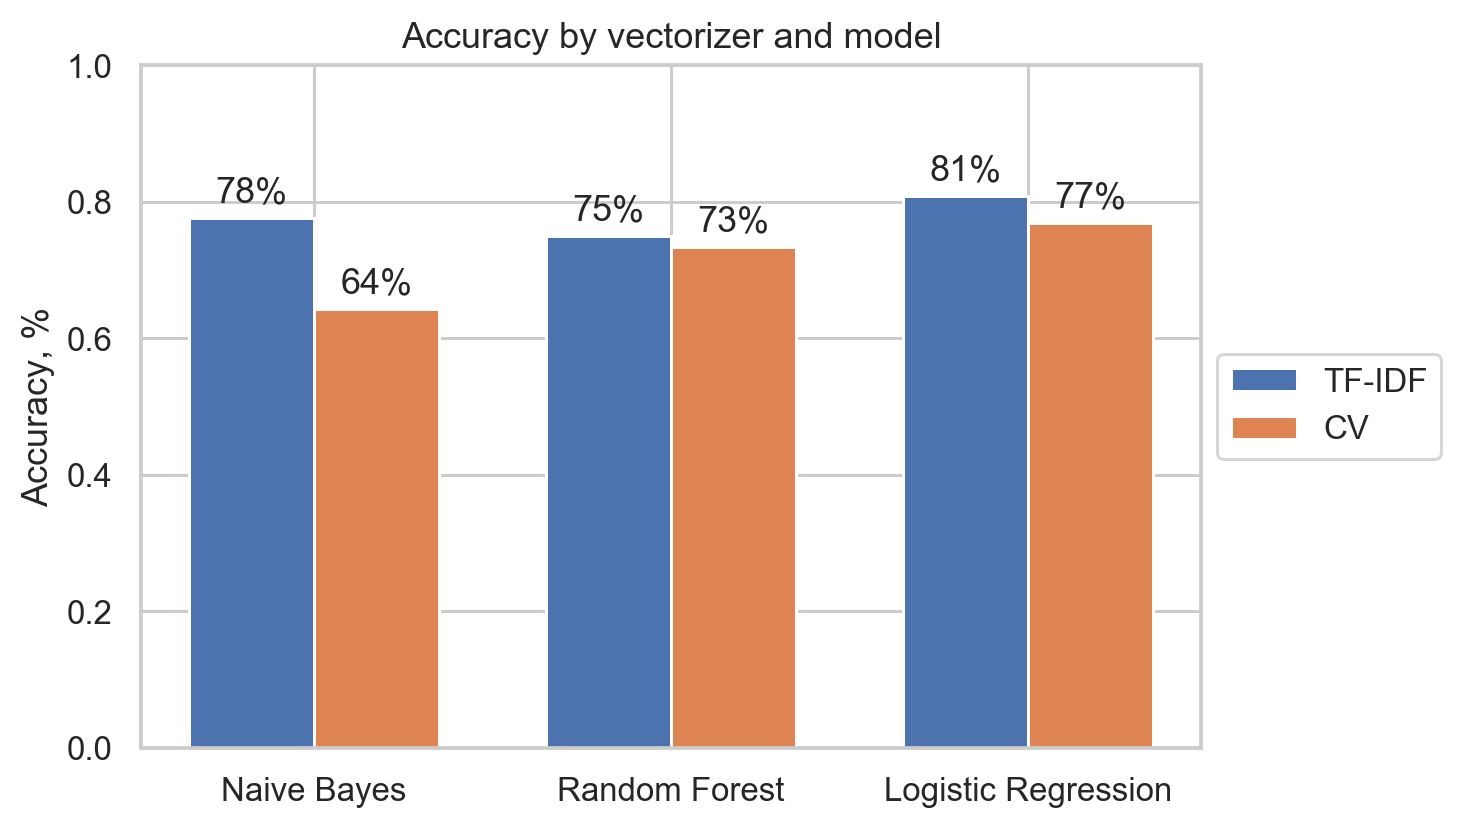

In [74]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

labels = ['Naive Bayes', 'Random Forest', 'Logistic Regression']

x = np.arange(len(labels))    # the label locations
width = 0.35                  # the width of the bars

fig, ax = plt.subplots(dpi=216)
rects1 = ax.bar(x - width/2, tf_acc, width, label='TF-IDF')
rects2 = ax.bar(x + width/2, cv_acc, width, label='CV')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy, %')
ax.set_title('Accuracy by vectorizer and model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 'right')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(0, 1)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.0f}%'.format(height*100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [77]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(title for title in df.Title)
print ("There are {} words in the combination of all titles.".format(len(text)))

There are 2182735 words in the combination of all titles.


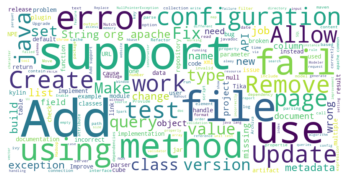

In [78]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()